# 5. Small Store (1.5 điểm)

Cho dữ liệu small_store.csv

Yêu cầu: Đọc dữ liệu, chuẩn hóa dữ liệu (nếu cần) và chọn một thuật toán thích hợp trong nhóm Association rule learning để tính toán mức độ kết hợp giữa các item.

### Tiền xử lý dữ liệu

In [1]:
# thư viện
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('small_store.csv')
if df.isna().any().any(): # Kiểm tra dữ liệu Null
    print('Có dữ liệu Null.')
else:
    print('Không có dữ liệu Null.')

Không có dữ liệu Null.


In [3]:
print('Dữ liệu có {} dòng, {} cột.'.format(df.shape[0],df.shape[1]))

Dữ liệu có 82 dòng, 2 cột.


In [4]:
df.head()

,Customer_Id,Products
0,1,bread
1,1,butter
2,1,eggs
3,1,milk
4,4,buns


In [5]:
df.tail()

,Customer_Id,Products
77,15,cheese
78,15,chips
79,15,mayo
80,15,mustard
81,15,soda


In [6]:
print('Thông tin dữ liệu.')
df.info()

Thông tin dữ liệu.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 2 columns):
Customer_Id    82 non-null int64
Products       82 non-null object
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


### 1. Áp dụng thuật toán (tự lựa chọn các tham số phù hợp cho thuật toán). In kết quả.

Vì dữ liệu nhỏ nên sử dụng ECLAT.

In [7]:
# source: https://gist.github.com/evertheylen/ece1e3494c233e17d04be0f8a23dd464
def tidlists(transactions):
    tl = defaultdict(set)
    for tid, t in enumerate(transactions):
        for item in t:
            tl[item].add(tid)
    return list(tl.items())

class IntersectAll:
    def __and__(self, other):
        return other
IntersectAll = IntersectAll()

def eclat(items, minsup=0, minlen=1):
    frequent_itemsets = {(): IntersectAll}
    def recurse(items, prefix):
        while len(items) > 0:
            item, item_tidlist = items.pop()
            l = prefix + (item,)  # l is the (ordered) tuple of items we are looking for
            new_tidlist = frequent_itemsets[prefix] & item_tidlist
            if len(new_tidlist) >= minsup:  # add frequent_itemsets to the new frequent_itemsets
                frequent_itemsets[l] = new_tidlist
            
            # define the new l-conditional database
            new_items = []
            for new_item, _item_tidlist in items:
                new_item_tidlist = _item_tidlist & item_tidlist
                if len(new_item_tidlist) >= minsup:
                    new_items.append((new_item, new_item_tidlist))
            
            # recurse, with l as prefix
            recurse(new_items, l)
    
    recurse(items.copy(), ())
    return {k: len(v) for k, v in frequent_itemsets.items() if len(k) >= minlen}

In [8]:
items = []
for i in range(df.Customer_Id.max()):
    items += [[]]
for i in range(df.shape[0]):
    items[df.Customer_Id[i]-1] += [df.Products[i]]
items

[['bread', 'butter', 'eggs', 'milk'],
 ['beer', 'bread', 'cheese', 'chips', 'mayo', 'soda'],
 ['banana', 'bread', 'butter', 'cheese', 'oranges'],
 ['buns', 'chips', 'beer', 'mustard', 'soda'],
 ['buns', 'chips', 'beer', 'mustard', 'pickels', 'soda'],
 ['bread', 'butter', 'chocolate', 'eggs', 'milk'],
 ['banana', 'chocolate', 'eggs', 'milk', 'oranges'],
 ['beer',
  'bread',
  'buns',
  'cheese',
  'chips',
  'chocolate',
  'mayo',
  'mustard',
  'soda'],
 ['banana', 'beer', 'bread', 'cheese', 'milk', 'oranges', 'soda'],
 ['bread', 'butter', 'chocolate', 'eggs', 'milk'],
 ['banana', 'chips', 'soda'],
 ['bread', 'butter', 'eggs', 'milk', 'oranges'],
 ['banana', 'beer', 'bread', 'cheese', 'butter', 'mustard'],
 ['bread', 'butter', 'eggs', 'milk'],
 ['beer', 'bread', 'cheese', 'chips', 'mayo', 'mustard', 'soda']]

In [9]:
tl = tidlists(items)
tl

[('bread', {0, 1, 2, 5, 7, 8, 9, 11, 12, 13, 14}),
 ('butter', {0, 2, 5, 9, 11, 12, 13}),
 ('eggs', {0, 5, 6, 9, 11, 13}),
 ('milk', {0, 5, 6, 8, 9, 11, 13}),
 ('beer', {1, 3, 4, 7, 8, 12, 14}),
 ('cheese', {1, 2, 7, 8, 12, 14}),
 ('chips', {1, 3, 4, 7, 10, 14}),
 ('mayo', {1, 7, 14}),
 ('soda', {1, 3, 4, 7, 8, 10, 14}),
 ('banana', {2, 6, 8, 10, 12}),
 ('oranges', {2, 6, 8, 11}),
 ('buns', {3, 4, 7}),
 ('mustard', {3, 4, 7, 12, 14}),
 ('pickels', {4}),
 ('chocolate', {5, 6, 7, 9})]

In [10]:
model = eclat(tl,3,2)
for i in list(model)[:5]:
    print(i, model[i])

('chocolate', 'milk') 3
('chocolate', 'milk', 'eggs') 3
('chocolate', 'eggs') 3
('chocolate', 'bread') 3
('mustard', 'buns') 3


### 2. Tìm kiếm thông tin từ kết quả: trong thông tin kết quả có 'soda' không? Nếu có thì 'soda' kết hợp với item nào?

In [11]:
for i in model.items():
    if 'soda' in i[0]:
        print(i)

(('mustard', 'buns', 'soda'), 3)
(('mustard', 'buns', 'soda', 'chips'), 3)
(('mustard', 'buns', 'soda', 'chips', 'beer'), 3)
(('mustard', 'buns', 'soda', 'beer'), 3)
(('mustard', 'soda'), 4)
(('mustard', 'soda', 'chips'), 4)
(('mustard', 'soda', 'chips', 'beer'), 4)
(('mustard', 'soda', 'beer'), 4)
(('buns', 'soda'), 3)
(('buns', 'soda', 'chips'), 3)
(('buns', 'soda', 'chips', 'beer'), 3)
(('buns', 'soda', 'beer'), 3)
(('soda', 'mayo'), 3)
(('soda', 'mayo', 'chips'), 3)
(('soda', 'mayo', 'chips', 'cheese'), 3)
(('soda', 'mayo', 'chips', 'cheese', 'beer'), 3)
(('soda', 'mayo', 'chips', 'cheese', 'beer', 'bread'), 3)
(('soda', 'mayo', 'chips', 'cheese', 'bread'), 3)
(('soda', 'mayo', 'chips', 'beer'), 3)
(('soda', 'mayo', 'chips', 'beer', 'bread'), 3)
(('soda', 'mayo', 'chips', 'bread'), 3)
(('soda', 'mayo', 'cheese'), 3)
(('soda', 'mayo', 'cheese', 'beer'), 3)
(('soda', 'mayo', 'cheese', 'beer', 'bread'), 3)
(('soda', 'mayo', 'cheese', 'bread'), 3)
(('soda', 'mayo', 'beer'), 3)
(('soda'

### 3. Cho biết 3 sản phẩm được mua nhiều nhất. Vẽ biểu đồ.

3 sản phẩm được mua nhiều nhất:

In [12]:
top3 = []
tl2 = tl.copy()
while len(top3) < 3:
    bestbuy = 0
    bestitem = ''
    r = ()
    for i in tl2:
        if len(i[1]) > bestbuy:
            bestbuy = len(i[1])
            bestitem = i[0]
            r = i
    top3 += [bestitem]
    tl2.remove(r)
print('3 sản phẩm được mua nhiều nhất là {}.'.format(top3))

3 sản phẩm được mua nhiều nhất là ['bread', 'butter', 'milk'].


Biểu đồ:

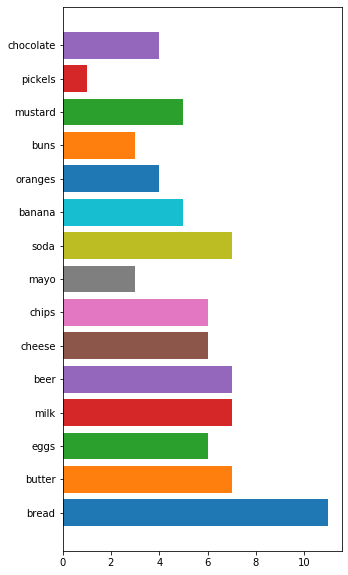

In [13]:
x, y = [], []
for i in tl:
    x += [i[0]]
    y += [len(i[1])]
plt.figure(figsize=(5,10))
for i in range(len(x)):
    plt.barh(x[i],y[i])
plt.show()

3 sản phẩm được mua phối hợp nhiều nhất:

In [14]:
bestbuy = 0
bestcombo = ''
for i in model.items():
    if (len(i[0]) == 3) and (i[1] > bestbuy):
        bestbuy = i[1]
        bestcombo = i[0]
print('3 sản phẩm được mua phối hợp nhiều nhất là {}.'.format(bestcombo))

3 sản phẩm được mua phối hợp nhiều nhất là ('soda', 'chips', 'beer').


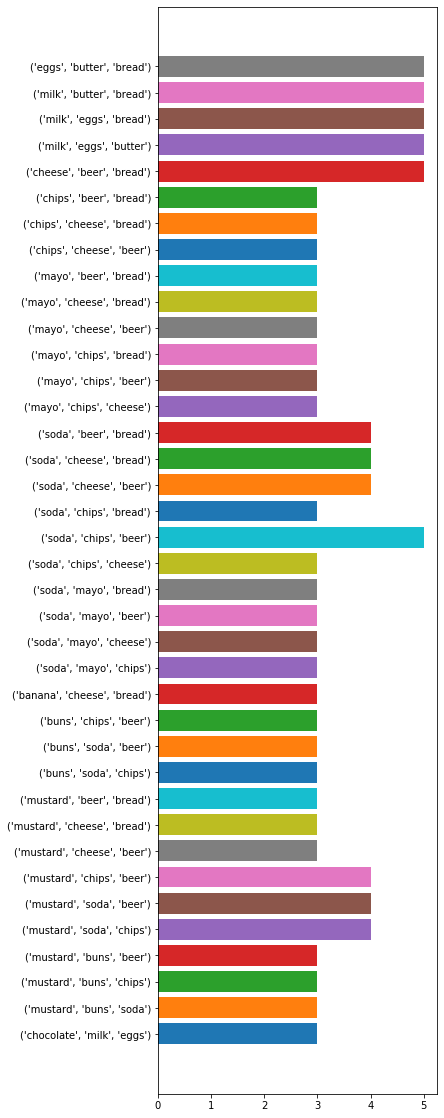

In [15]:
x, y = [], []
for i in model.items():
    if (len(i[0]) == 3):
        x += [str(i[0])]
        y += [i[1]]
plt.figure(figsize=(5,20))
for i in range(len(x)):
    plt.barh(x[i],y[i])
plt.show()